<a href="https://colab.research.google.com/github/ConnectNitish/ML_hack_Qipl/blob/main/N_Good_Working_RF_Backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Sabber Ahamed

Objective: The primary goal of this code is to develop a machine learning model that can classify the labels properly and address dataset imbalance. The dataset has three classes (1, 2, and 3). There are three problems in the challenge. In each problem, there is some specific task that needs to be done. In the following subsections, I describe three techniques I used to overcome the data imbalance problem.

Codes and libraries: This project requires Python  3. I have Used python 3.0. The following Python libraries are also required:

<li> NumPy
<li> Pandas
<li> matplotlib
<li> scikit-learn
<li> seaborn

In [465]:
import numpy as np
import pandas as pd
import warnings

## Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

## Sklearn Libraries
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve

# Define random state
random_state = 2018
np.random.seed(random_state)
warnings.filterwarnings('ignore')

In [466]:
# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 14
    }

plt.rc('font', **font)

## Import datasets

In [467]:
train = pd.read_csv('./train_data.csv')
test = pd.read_csv('./test_data.csv')
# train = pd.read_csv('https://raw.githubusercontent.com/ConnectNitish/ML_hack_Qipl/main/Intermediate/without_dup_rows.csv')
# test = pd.read_csv('https://raw.githubusercontent.com/ConnectNitish/ML_hack_Qipl/main/Intermediate/test_csv.csv')

## Exploratory data analysis

In [468]:
train.shape

(80000, 8)

In [469]:
test.shape

(35000, 9)

In [470]:
train.head()

,Insects,Crop,Soil,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not_used,Crop_status
0,188,Feed,clay,1,0,0.0,0,0
1,209,Feed,clay,1,0,0.0,0,1
2,257,Feed,clay,1,0,0.0,0,1
3,257,Feed,silt,1,0,0.0,0,1
4,342,Feed,clay,1,0,0.0,0,1


In [471]:
train.describe()

,Insects,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not_used,Crop_status
count,80000.000000,80000.000000,80000.000000,71945.000000,80000.000000,80000.000000
mean,1400.020875,2.267587,25.846750,28.664480,9.549088,0.192312
std,849.792471,0.463748,15.557246,12.424751,9.905547,0.455912
min,150.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,731.000000,2.000000,15.000000,20.000000,0.000000,0.000000
50%,1212.000000,2.000000,20.000000,28.000000,7.000000,0.000000
75%,1898.000000,3.000000,40.000000,37.000000,16.000000,0.000000
max,4097.000000,3.000000,95.000000,67.000000,50.000000,2.000000


### Class distribution

In [472]:
label_count = train.groupby('Crop_status', as_index = False).count()

In [473]:
label_count

,Crop_status,Insects,Crop,Soil,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not_used
0,0,66716,66716,66716,66716,66716,59999,66716
1,1,11183,11183,11183,11183,11183,10075,11183
2,2,2101,2101,2101,2101,2101,1871,2101


In [474]:
class_name = list(label_count['Crop_status'])
# count = list(label_count[1])

In [475]:
class_name

[0, 1, 2]

In [476]:
# count

In [477]:
# index = np.arange(len(class_name))
# # plt.bar(class_name, count)
# sns.barplot(x=class_name, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
# plt.xlabel('Class', fontsize=15)
# plt.ylabel('Number of data', fontsize=15)
# plt.xticks(index, class_name, fontsize=15)
# plt.title('Class distribution')
# plt.show()

In [478]:
# dropped_df = train.dropna(how='all')

In [479]:
# dropped_df.describe()

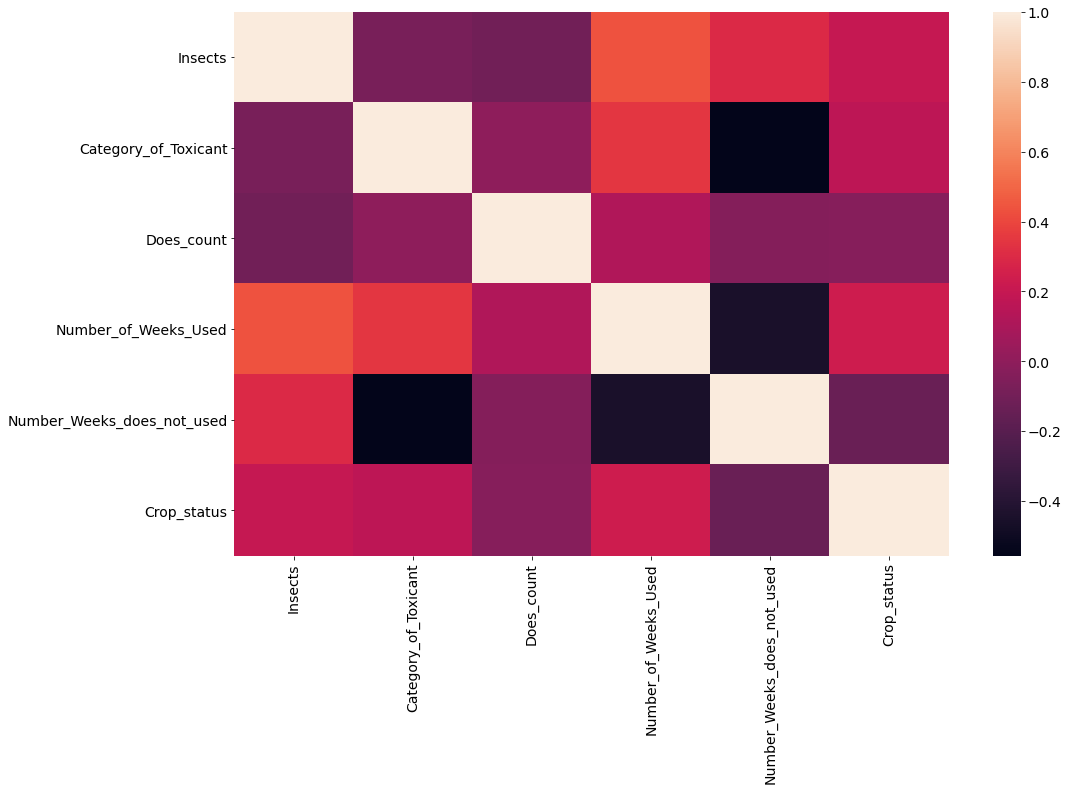

In [480]:
import seaborn as sns
cor = train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)
plt.show()

## To handle data imbalance issue, I have used the following three techniques :
### A. Create ensembel class

In [481]:

class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = random_state).split(X, y))

        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='macro')
                f1 = f1_score(Y_valid, valid_pred, average='macro')
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                print( "Model- {} and CV- {} recall: {}, f1_score: {}".format(i, j, recall, f1))
            
        return train_pred, test_pred, recall_scores, f1_scores

In [482]:
train

,Insects,Crop,Soil,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not_used,Crop_status
0,188,Feed,clay,1,0,0.0,0,0
1,209,Feed,clay,1,0,0.0,0,1
2,257,Feed,clay,1,0,0.0,0,1
3,257,Feed,silt,1,0,0.0,0,1
4,342,Feed,clay,1,0,0.0,0,1
...,...,...,...,...,...,...,...,...
79995,209,Food,silt,2,20,12.0,6,0
79996,232,Food,silt,2,20,12.0,9,0
79997,256,Food,silt,2,10,14.0,10,0
79998,256,Food,silt,2,10,16.0,8,0


In [483]:
data = train

In [484]:
mean_of_Number_Weeks_does_not_used = data['Number_Weeks_does_not_used'].mean()
mean_of_Number_Weeks_does_not_used

9.5490875

In [485]:
data['Number_of_Weeks_Used'].fillna((mean_of_Number_Weeks_does_not_used), inplace=True)

In [486]:
target = 'Crop_status'

In [487]:
target = 'Crop_status'


binary_features = ['Crop', 'Soil']

#  column  Crop
#  distinct Values  ['Feed', 'Food']
#  column  Soil
#  distinct Values  ['clay', 'silt']

# value of the Column to be said as one ( 1) 
binary_positives = ['Feed', 'clay']

# ordering 
# ordinal_features = ['emp_length']

# no ordering 
nominal_features = ['Category_of_Toxicant']

In [488]:
# Encoding functions

def binary_encode(df, column, positive_value):
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)

def ordinal_encode(df, column, ordering):
    df[column] = df[column].apply(lambda x: ordering.index(x))

def onehot_encode(df, column):
    dummies = pd.get_dummies(df[column])
    df_new = pd.concat([df, dummies], axis=1)
    df_new = df_new.drop(column, axis=1)
    return df_new

In [489]:
# Perform encoding

for feature, positive_value in zip(binary_features, binary_positives):
    binary_encode(data, feature, positive_value)

# not required here 
# ordinal_encode(data, 'emp_length', emp_ordering)

# adding a new columns 
for feature in nominal_features:
    data = onehot_encode(data, feature)

In [490]:
y = data[target]
X = data.drop(target,axis=1)

In [491]:
X

,Insects,Crop,Soil,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not_used,1,2,3
0,188,1,1,0,0.0,0,1,0,0
1,209,1,1,0,0.0,0,1,0,0
2,257,1,1,0,0.0,0,1,0,0
3,257,1,0,0,0.0,0,1,0,0
4,342,1,1,0,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
79995,209,0,0,20,12.0,6,0,1,0
79996,232,0,0,20,12.0,9,0,1,0
79997,256,0,0,10,14.0,10,0,1,0
79998,256,0,0,10,16.0,8,0,1,0


In [492]:
xtrain, X_test, ytrain, y_test = train_test_split(X, y, train_size=0.95, random_state=42)

In [493]:
print(xtrain.shape)

(76000, 9)


In [494]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer

# cv = StratifiedKFold(n_splits = 4, shuffle=True, random_state = random_state)

# rdf = RandomForestClassifier(random_state = random_state) 
# scoring = {'Recall': make_scorer(recall_score),
#            'f1_score': make_scorer(f1_score)
#           }

# params = {'max_depth': [6, 8, 10, 20,25], 
#               'min_samples_split': [5, 10, 15],
#               'min_samples_leaf' : [4, 8, 12],
#               'n_estimators' : [300, 400, 500,700]
#              }

# grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
# grid_clf.fit(xtrain, ytrain)

In [495]:
# print(grid_clf.best_estimator_)
# print(grid_clf.best_params_)

In [496]:
# rdf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=20, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=12, min_samples_split=5,
#             min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
#             oob_score=False,
#             random_state=random_state,
#             verbose=0, warm_start=False)

# rdf1 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
#                        criterion='gini', max_depth=20, max_features='auto',
#                        max_leaf_nodes=None, max_samples=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=12, min_samples_split=5,
#                        min_weight_fraction_leaf=0.0, n_estimators=500,
#                        n_jobs=None, oob_score=False, random_state=2018,
#                        verbose=0, warm_start=False)

# rdf1 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
#                        criterion='gini', max_depth=10, max_features='auto',
#                        max_leaf_nodes=None, max_samples=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=12, min_samples_split=5,
#                        min_weight_fraction_leaf=0.0, n_estimators=300,
#                        n_jobs=None, oob_score=False, random_state=2018,
#                        verbose=0, warm_start=False)

In [497]:
xtrain

,Insects,Crop,Soil,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not_used,1,2,3
10268,1056,0,0,60,34.000000,0,0,0,1
43187,1385,1,1,10,23.000000,18,0,1,0
20902,1385,1,0,5,32.000000,0,0,0,1
35182,448,1,1,30,14.000000,11,0,1,0
13676,1056,0,1,10,19.000000,22,0,1,0
...,...,...,...,...,...,...,...,...,...
6265,2139,0,1,40,9.549088,8,0,1,0
54886,577,0,0,40,23.000000,8,0,1,0
76820,2688,1,1,5,51.000000,0,0,0,1
860,851,0,1,10,30.000000,10,0,1,0


In [498]:
train.shape

(80000, 8)

In [499]:
# # Perform encoding

# for feature, positive_value in zip(binary_features, binary_positives):
#     binary_encode(data, feature, positive_value)

# # not required here 
# # ordinal_encode(data, 'emp_length', emp_ordering)

# # adding a new columns 
# for feature in nominal_features:
#     train = onehot_encode(train, feature)

In [500]:
# base_models = [rdf1]
# n_splits = 5
# lgb_stack = Create_ensemble(n_splits = n_splits, base_models = base_models)        

# xtrain = train.drop([target], axis=1)
# ytrain = train[target].values

## Test Data parsing


In [501]:
test = pd.read_csv('https://raw.githubusercontent.com/ConnectNitish/ML_hack_Qipl/main/Intermediate/test_csv.csv')

In [502]:
test.shape

(35000, 9)

In [503]:
test = test.drop(['ID','Season'],axis=1)

In [504]:
test.shape

(35000, 7)

In [505]:
test

,Insects,Crop,Soil,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not used
0,188,Feed,silt,1,0,NaN,0
1,410,Feed,silt,1,0,0.0,0
2,626,Feed,clay,1,0,0.0,0
3,731,Feed,clay,1,0,0.0,0
4,789,Food,clay,1,0,0.0,0
...,...,...,...,...,...,...,...
34995,677,Food,silt,2,40,27.0,3
34996,731,Food,silt,2,10,8.0,20
34997,732,Food,silt,2,10,10.0,20
34998,731,Food,silt,2,10,31.0,2


In [506]:
# Perform encoding

for feature, positive_value in zip(binary_features, binary_positives):
    binary_encode(test, feature, positive_value)

# not required here 
# ordinal_encode(data, 'emp_length', emp_ordering)

# adding a new columns 
for feature in nominal_features:
    test = onehot_encode(test, feature)

In [507]:
test.shape

(35000, 9)

In [508]:
test['Number_of_Weeks_Used'].fillna((mean_of_Number_Weeks_does_not_used), inplace=True)
# test = scaler.transform(test)

In [509]:
# train_pred, test_pred, recall_scores, f1_scores = lgb_stack.predict(xtrain, ytrain, test)

In [510]:
# print('1. The F-1 score of the model {}\n'.format(f1_score(ytrain, train_pred, average='macro')))
# print('2. The recall score of the model {}\n'.format(recall_score(ytrain, train_pred, average='macro')))
# print('3. Classification report \n {} \n'.format(classification_report(ytrain, train_pred)))
# print('4. Confusion matrix \n {} \n'.format(confusion_matrix(ytrain, train_pred)))

In [511]:
# tpred = pd.DataFrame(test_pred)
# final_tpred = tpred.mode(axis=1)

In [512]:
# np.unique(final_tpred)

In [513]:
# final_tpred.to_csv('predicted_labels_1.csv', index=False, header= False)

The datasets used in problem-1 are highly unbalance. Therefore, all the evaluation metrics shows the expected random performance. Due to the unbalance data, the probabilities for minor classes (class-2 and 3) are inaccurate. But we can still get good predictions by choosing a more appropriate probability cutoff. In the problem-3 section, I will imporve the model performance by choosing a cutoff by ovserving the minor class probability distribution and ROC curve and by setting unequal importance of the class.

### Modified Ensemble

In this problem the labels have unequal importance, in the sense that we want to penalize the model most if it misclassified label 3, a little less for 2 and the least for label 1. Additionally, in case of a misclassification, it is preferable to over-predict a label than under-predict (i.e. misclassifying label 3 as 2 is worse than misclassifying label 2 as 3). To implement the above constraints I would rebuild problem-1 model in following steps:

<li> <b>Step 1: </b>Predict probabilities instead of actual prediction.
<li> <b>Step 2: </b>Set the class weight.
<li> <b>Step 3: </b>Get probability distribution of minor class.
<li> <b>Step 4: </b>From the ROC curve and probability distribution obtain probability thresholds for classes.
<li> <b>Step 5: </b>Finally use the threshold to over-predict a label than under-predict.

In [514]:

class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        no_class = len(np.unique(y))

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = random_state).split(X, y))

        train_proba = np.zeros((X.shape[0], no_class))
        test_proba = np.zeros((T.shape[0], no_class))
        
        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='macro')
                f1 = f1_score(Y_valid, valid_pred, average='macro')
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                ## Probabilities
                valid_proba = clf.predict_proba(X_valid)
                train_proba[valid_idx, :] = valid_proba
                test_proba  += clf.predict_proba(T)
                
                print( "Model- {} and CV- {} recall: {}, f1_score: {}".format(i, j, recall, f1))
                
            test_proba /= self.n_splits
            
        return train_proba, test_proba, train_pred, test_pred

### B. Set class weight

In [515]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer

# cv = StratifiedKFold(n_splits = 4, shuffle=True, random_state = random_state)

# rdf = RandomForestClassifier(random_state = random_state) 
# scoring = {'Recall': make_scorer(recall_score),
#            'f1_score': make_scorer(f1_score)
#           }

# params = {'max_depth': [6, 8, 10, 20,25], 
#               'min_samples_split': [5, 10, 15],
#               'min_samples_leaf' : [4, 8, 12],
#               'n_estimators' : [300, 400, 500,700]
#              }

# grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
# grid_clf.fit(xtrain, ytrain)

In [516]:
# print(grid_clf.best_estimator_)
# print(grid_clf.best_params_)

In [517]:
# break

In [518]:
from sklearn.ensemble import RandomForestClassifier
class_weight = dict({1:1.9, 2:35, 3:180})

# rdf = RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
#             max_depth=8, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=4, min_samples_split=10,
#             min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
#             oob_score=False,
#             random_state=random_state,
#             verbose=0, warm_start=False)

# rdf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
#                        criterion='entropy', max_depth=20, max_features='auto',
#                        max_leaf_nodes=None, max_samples=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=12, min_samples_split=5,
#                        min_weight_fraction_leaf=0.0, n_estimators=500,
#                        n_jobs=None, oob_score=False, random_state=2018,
#                        verbose=0, warm_start=False)

# 90 - 10 / mean 
rdf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=2018,
                       verbose=0, warm_start=False)
# {'max_depth': 25, 'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 700}

In [519]:
train.shape

(80000, 8)

In [520]:
# Perform encoding

for feature, positive_value in zip(binary_features, binary_positives):
    binary_encode(data, feature, positive_value)

# not required here 
# ordinal_encode(data, 'emp_length', emp_ordering)

# adding a new columns 
for feature in nominal_features:
    train = onehot_encode(train, feature)

In [521]:
base_models = [rdf]
n_splits = 7
lgb_stack = Create_ensemble(n_splits = n_splits, base_models = base_models)        

xtrain = train.drop([target], axis=1)
ytrain = train[target]
# ytrain = label_binarize(Y, classes=[0, 1, 2])

In [522]:
xtrain.shape

(80000, 9)

In [523]:
test.shape

(35000, 9)

In [524]:
train_proba, test_proba, train_pred, test_pred = lgb_stack.predict(xtrain, ytrain, test)

Model- 0 and CV- 0 recall: 0.3799235457079717, f1_score: 0.38477763464470005
Model- 0 and CV- 1 recall: 0.3838556020367326, f1_score: 0.39087459169466393
Model- 0 and CV- 2 recall: 0.37902046970807374, f1_score: 0.38385546087175504
Model- 0 and CV- 3 recall: 0.38587129397330067, f1_score: 0.39369678547636466
Model- 0 and CV- 4 recall: 0.38402774533905676, f1_score: 0.39118239954640327
Model- 0 and CV- 5 recall: 0.3850014216098405, f1_score: 0.39229636611617485
Model- 0 and CV- 6 recall: 0.38458203044116446, f1_score: 0.39136838919524597


In [525]:
print('1. The F-1 score of the model {}\n'.format(f1_score(ytrain, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(ytrain, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(ytrain, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(ytrain, train_pred)))

1. The F-1 score of the model 0.38973021916325684

2. The recall score of the model 0.3831826944707612

3. Classification report 
               precision    recall  f1-score   support

           0       0.86      0.99      0.92     66716
           1       0.54      0.16      0.25     11183
           2       0.00      0.00      0.00      2101

    accuracy                           0.84     80000
   macro avg       0.47      0.38      0.39     80000
weighted avg       0.79      0.84      0.80     80000
 

4. Confusion matrix 
 [[65734   982     0]
 [ 9346  1837     0]
 [ 1513   588     0]] 



In [526]:
test_pred.shape

(35000, 7)

In [527]:
final_test_output_unseen_data = []
ROW_ID_List = []

for index,item in enumerate(test_pred):
  # print(item)
  dict_temp = {}
  for iter in item:
    if iter not in dict_temp.keys():
      dict_temp[iter] = 0
    dict_temp[iter] = dict_temp[iter] + 1

  max_item = 0
  max_item_value = 0
  for iter in dict_temp.keys():
    if max_item < dict_temp[iter]:
      max_item = dict_temp[iter]
      max_item_value = iter
  
  final_test_output_unseen_data.append(max_item_value)
  ROW_ID_List.append(index+1)

  # if len(dict_temp.keys()) > 1:
  #   print(item)
  #   common = common + 1
  #   if common > 5:
  #     break
print(len(final_test_output_unseen_data))
print(len(ROW_ID_List))

# print(common)

35000
35000


In [528]:
ROW_ID_List[0]

1

In [529]:
train_pred.shape

(80000, 1)

In [530]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [531]:
pwd

'/content'

In [532]:
# model = None
# path_for_saving_models = '/content/gdrive/My Drive/QC_HACK/intermediate/models/'
# model = lgb_stack.save_model(path_for_saving_models + 'Random_Forest_best_param_lgb_stack')

In [533]:
# ROW_ID	Crop_status
import pandas
df = pandas.DataFrame(data={"ROW_ID": ROW_ID_List, "Crop_status": final_test_output_unseen_data})
df.to_csv("./Run_9_N_Output_RF_90_10_mean_unseen_data.csv", sep=',',index=False)
# df.to_csv("/content/gdrive/.shortcut-targets-by-id/1oQde4ds0EEqfk3q1idaW-UJasMRVfzOu/QC_HACK/intermediate/Outputs/Run_9_N_Output_RF_90_10_mean_unseen_data.csv", sep=',',index=False)

In [534]:
# # Predicting the Test set results
# y_pred = tree_classifier.predict(X_test)
# #Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
# definitions = target_mappings
# reversefactor = dict(zip(range(3),definitions))
# y_test = np.vectorize(reversefactor.get)(y_test)
# y_pred = np.vectorize(reversefactor.get)(y_pred)
# # Making the Confusion Matrix
# print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

### Probability distribution for all classes

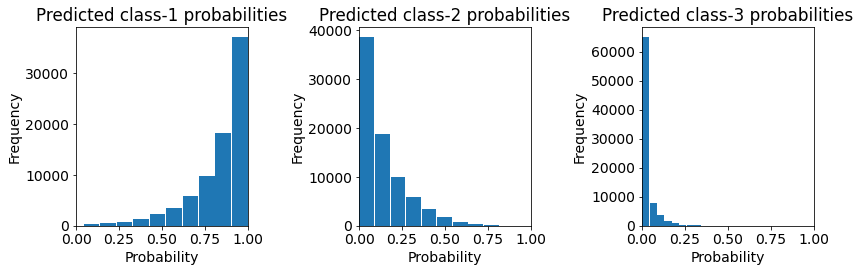

In [535]:
# histogram of predicted probabilities
plt.figure(figsize=(12, 4))
nclasses = 3
for i in range(nclasses):
    
    plt.subplot(1, 3, i+1)
    plt.hist(train_proba[:, i], bins=10, histtype='bar', rwidth=0.95)
    plt.xlim(0,1)
    plt.title('Predicted class-{} probabilities'.format(i+1))
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### C. Over-Predict a Label than Under-Predict:

In [536]:
def re_predict(data, threshods):

    argmax = np.argmax(data)

    ## If the argmax is 2 (class-3) then ovbiously return this highest label
    if argmax == 2: 
        return (argmax +1)

    # If argmax is 1 (class-2) there is a chnace that, label is class-2 if
    # the probability of the class is greater than the threshold otherwise obviously
    # return this highest label (class-3)
    elif argmax == 1:
        if data[argmax] >= threshods[argmax] : 
            return (argmax +1)
        else:
            return (argmax +2)

    # If the argmax is 0 (class-1) then there are chances that label is class-1 if
    # the probability of the class is greater than the threshold otherwise label can be
    # either next two highest labels (class-2 or class-3). To determine the exact class
    # class, we have to consider four cases.
    # case A : if class_2_prob >= threshold and class_3_prob < threshold then pick class-2
    # case B : if class_3_prob >= threshold and class_2_prob < threshold then pick class-3
    # case C : if class_2_prob < threshold and class_3_prob < threshold then pick class-1
    # case D : if class_2_prob > threshold and class_3_prob > threshold then pick class-3

    elif argmax == 0:

        if data[argmax] >= threshods[argmax] : 
            return (argmax +1)
        else:
            # case A : if class_2_prob >= threshold and class_3_prob < threshold then pick class-2
            if data[argmax + 1] >= threshods[argmax + 1] and data[argmax + 2] < threshods[argmax + 2]:
                return (argmax + 2)

            # case B : if class_3_prob >= threshold and class_2_prob < threshold then pick class-3
            if data[argmax + 2] >= threshods[argmax + 2] and data[argmax + 1] < threshods[argmax + 1]:
                return (argmax + 3)

            # case C : if class_2_prob < threshold and class_3_prob < threshold then pick class-1
            if data[argmax + 1] < threshods[argmax + 1] and data[argmax + 2] < threshods[argmax + 2]:
                return (argmax + 1)

            # case D : if class_2_prob > threshold and class_3_prob > threshold then pick class-3
            if data[argmax + 1] > threshods[argmax + 1] and data[argmax + 2] > threshods[argmax + 2]:
                return (argmax + 3)

    

### Finding threshold probability of classes

In [537]:
from sklearn.preprocessing import label_binarize

y = label_binarize(ytrain, classes=[1, 2, 3])
_, _, th1 = roc_curve(y[:, 0], train_proba[:, 0])
_, _, th2 = roc_curve(y[:, 1], train_proba[:, 1])
_, _, th3 = roc_curve(y[:, 2], train_proba[:, 2])

In [538]:
print(np.median(th1))
print(np.median(th2))
print(np.median(th3))

0.7722259409833026
0.2859796744174089
0.01267625617125031


In [539]:
threshold = [0.47, 0.30, 0.15]
new_pred = []
for i in range(train_pred.shape[0]):
    new_pred.append(re_predict(train_proba[i, :], threshold))

In [540]:
print('1. The F-1 score of the model {}\n'.format(f1_score(ytrain, new_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(ytrain, new_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(ytrain, new_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(ytrain, new_pred)))

1. The F-1 score of the model 0.10653794500869057

2. The recall score of the model 0.2782920976768173

3. Classification report 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     66716
           1       0.12      0.81      0.21     11183
           2       0.17      0.30      0.22      2101
           3       0.00      0.00      0.00         0

    accuracy                           0.12     80000
   macro avg       0.07      0.28      0.11     80000
weighted avg       0.02      0.12      0.03     80000
 

4. Confusion matrix 
 [[    0 65460  1123   133]
 [    0  9058  1977   148]
 [    0  1426   637    38]
 [    0     0     0     0]] 



In [541]:
test_proba.shape

(35000, 3)

In [542]:
final_tpred_prob3 = []
for i in range(test_proba.shape[0]):
    final_tpred_prob3.append(re_predict(test_proba[i, :], threshold))

In [543]:
tpred_prob3 = pd.DataFrame(final_tpred_prob3)
tpred_prob3.to_csv('final.csv', index=False, header=False)